In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import os
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
df_shoes = pd.read_csv('post_analysis_shoes.csv')
df_shoes.shape

(8064, 18)

In [3]:
def plot_value_counts(df,column,kind,rotation=None):
    if(kind == 'barh'):
        plt.figure(figsize=(10,25))
    else:
        plt.figure(figsize=(16,5))
    (df[column].value_counts()/len(df)).plot(kind=kind,title=f"{column}")
    if(rotation):
        plt.xticks(rotation=rotation)
    plt.show()

In [4]:
popular_brands = ['olympikus', 'under_armour', 'nike', 'adidas', 'mizuno','asics','puma','fila']

df_shoes = df_shoes[df_shoes['brand'].isin(popular_brands)]

['olympikus', 'nike', 'adidas', 'asics', 'puma', 'mizuno', 'fila']


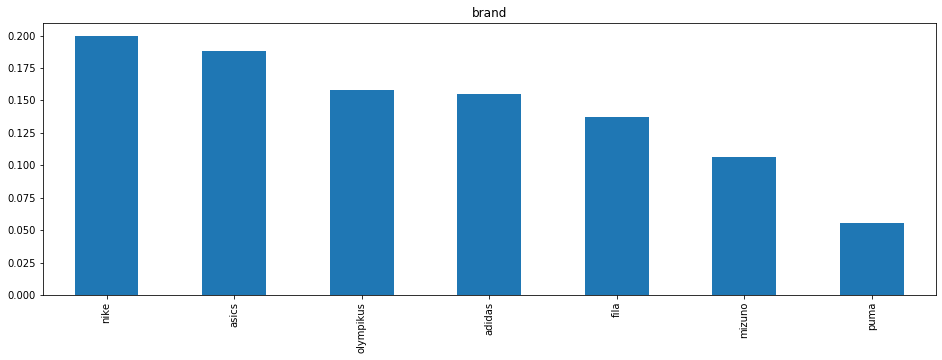

In [5]:
print(list(df_shoes['brand'].unique()))
    
plot_value_counts(df_shoes,'brand','bar')

# Preprocessing Functions

In [6]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
base_path = '/home/raphael/Documents/Projects/netshoes_ml_project/netshoes/images/'
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.15,
                                            height_shift_range=.15,
                                            horizontal_flip=True,
                                            zoom_range=0.5)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [11]:
IMG_SHAPE = (240,240)
epochs = 100

checkpoint_path = './brand_model/drop25_lr0001_b1'

In [13]:
efficient_net_url = "https://tfhub.dev/google/efficientnet/b1/feature-vector/1"

if(not os.path.exists(checkpoint_path)):
    os.makedirs(checkpoint_path)

    feature_extractor_layer = hub.KerasLayer(efficient_net_url,
                                         input_shape=IMG_SHAPE+(3,))
    feature_extractor_layer.trainable = False

    model = Sequential([
        feature_extractor_layer,
        Dropout(0.25),
        BatchNormalization(),
        Dense(df_shoes['brand'].nunique())
    ])
    initial_epoch = 0
else:
    model = tf.keras.models.load_model(checkpoint_path)
    initial_epoch = epochs

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              6575232   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 6,589,319
Trainable params: 11,527
Non-trainable params: 6,577,792
_________________________________________________________________


In [9]:
df_shoes['images'] = df_shoes['images'].str.split(',')
df_data = df_shoes.explode('images')[['images','brand']]
df_data['images'] = base_path + df_data['images']
df_data.shape

(17495, 2)

In [12]:
train, valid_test = train_test_split(df_data,
                                test_size=0.15,
                                stratify=df_data['brand'].values,
                                random_state=42)

valid, test = train_test_split(valid_test,
                                test_size=0.25,
                                stratify=valid_test['brand'].values,
                                random_state=42)

train_data_gen = train_image_generator.flow_from_dataframe(train,
                                          x_col='images',
                                          y_col='brand',
                                          shuffle=True,
                                          batch_size=64,
                                          target_size=IMG_SHAPE)

val_data_gen = validation_image_generator.flow_from_dataframe(valid,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

test_data_gen = validation_image_generator.flow_from_dataframe(test,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

Found 14870 validated image filenames belonging to 7 classes.
Found 1968 validated image filenames belonging to 7 classes.
Found 657 validated image filenames belonging to 7 classes.


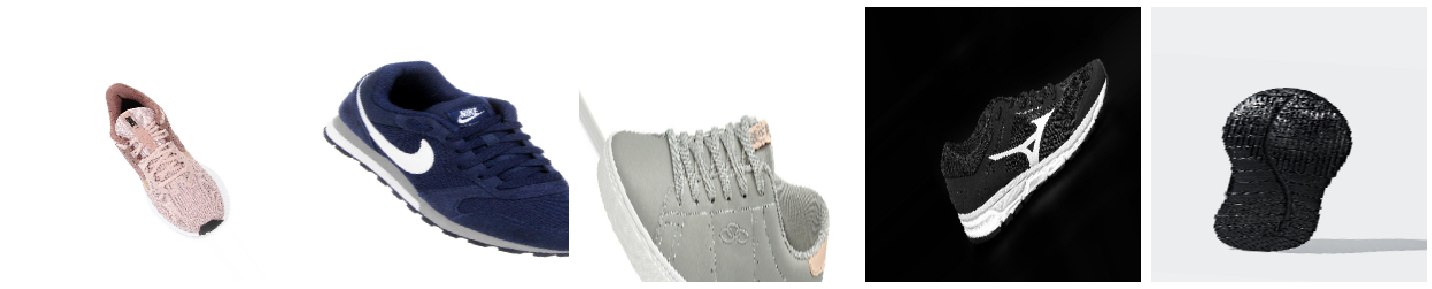

In [13]:
sample_training_images, _ = next(train_data_gen)

plot_images(sample_training_images[:5])

In [16]:
initial_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

logdir = f"{checkpoint_path}_2/logs/scalars/"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       monitor='val_acc',
                                       mode='max',
                                       save_weights_only=False),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch=0,update_freq='batch')
]



history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=100,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    callbacks=callbacks,
    initial_epoch=75
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 232 steps, validate for 30 steps
Epoch 76/100
231/232 [============================>.] - ETA: 1s - loss: 1.0159 - acc: 0.6359INFO:tensorflow:Assets written to: ./brand_model/drop25_lr0001_b1_2/assets


INFO:tensorflow:Assets written to: ./brand_model/drop25_lr0001_b1_2/assets


232/232 [==============================] - 315s 1s/step - loss: 1.0154 - acc: 0.6361 - val_loss: 0.8976 - val_acc: 0.6917
Epoch 77/100
231/232 [============================>.] - ETA: 1s - loss: 1.0248 - acc: 0.6364INFO:tensorflow:Assets written to: ./brand_model/drop25_lr0001_b1_2/assets


INFO:tensorflow:Assets written to: ./brand_model/drop25_lr0001_b1_2/assets


232/232 [==============================] - 311s 1s/step - loss: 1.0256 - acc: 0.6363 - val_loss: 0.8966 - val_acc: 0.7042
Epoch 78/100
232/232 [==============================] - 303s 1s/step - loss: 1.0174 - acc: 0.6389 - val_loss: 0.8895 - val_acc: 0.7021
Epoch 79/100
232/232 [==============================] - 303s 1s/step - loss: 1.0187 - acc: 0.6372 - val_loss: 0.8934 - val_acc: 0.6969
Epoch 80/100
231/232 [============================>.] - ETA: 1s - loss: 1.0206 - acc: 0.6370INFO:tensorflow:Assets written to: ./brand_model/drop25_lr0001_b1_2/assets


INFO:tensorflow:Assets written to: ./brand_model/drop25_lr0001_b1_2/assets


232/232 [==============================] - 307s 1s/step - loss: 1.0211 - acc: 0.6366 - val_loss: 0.8862 - val_acc: 0.7120
Epoch 81/100
232/232 [==============================] - 303s 1s/step - loss: 1.0107 - acc: 0.6392 - val_loss: 0.8798 - val_acc: 0.7104
Epoch 82/100
232/232 [==============================] - 303s 1s/step - loss: 1.0263 - acc: 0.6325 - val_loss: 0.8824 - val_acc: 0.7104
Epoch 83/100
231/232 [============================>.] - ETA: 1s - loss: 1.0161 - acc: 0.6413INFO:tensorflow:Assets written to: ./brand_model/drop25_lr0001_b1_2/assets


INFO:tensorflow:Assets written to: ./brand_model/drop25_lr0001_b1_2/assets


232/232 [==============================] - 308s 1s/step - loss: 1.0159 - acc: 0.6413 - val_loss: 0.8756 - val_acc: 0.7130
Epoch 84/100
232/232 [==============================] - 303s 1s/step - loss: 1.0176 - acc: 0.6387 - val_loss: 0.8857 - val_acc: 0.7000
Epoch 85/100
232/232 [==============================] - 304s 1s/step - loss: 1.0246 - acc: 0.6320 - val_loss: 0.8827 - val_acc: 0.7052
Epoch 86/100
232/232 [==============================] - 303s 1s/step - loss: 1.0155 - acc: 0.6346 - val_loss: 0.8803 - val_acc: 0.7109
Epoch 87/100
232/232 [==============================] - 307s 1s/step - loss: 1.0077 - acc: 0.6391 - val_loss: 0.8851 - val_acc: 0.7047
Epoch 88/100
232/232 [==============================] - 312s 1s/step - loss: 1.0061 - acc: 0.6451 - val_loss: 0.8770 - val_acc: 0.7130
Epoch 89/100
232/232 [==============================] - 312s 1s/step - loss: 1.0184 - acc: 0.6379 - val_loss: 0.8829 - val_acc: 0.7068
Epoch 90/100
232/232 [==============================] - 316s 1s/step

KeyboardInterrupt: 

In [14]:
model = tf.keras.models.load_model(checkpoint_path)

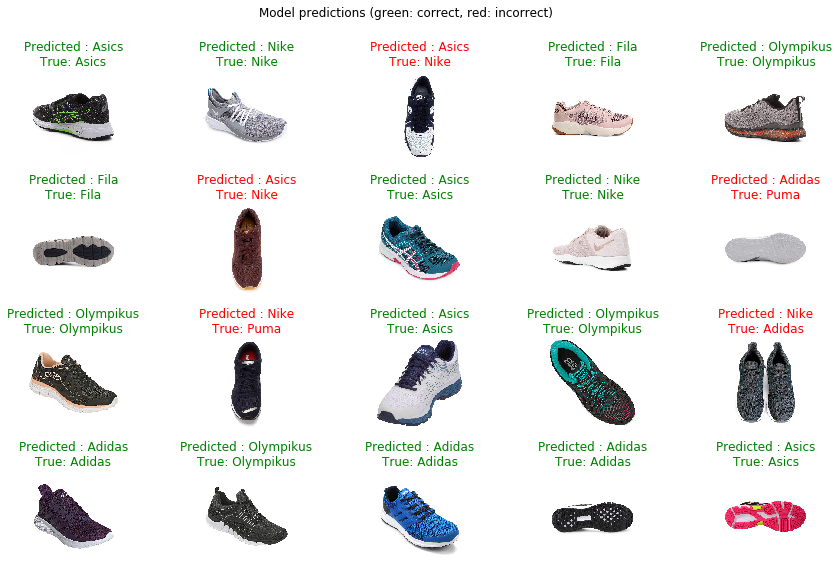

In [19]:
class_names = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

image_batch, label_batch = test_data_gen.next()

predicted_batch = model.predict(image_batch)
real_id = np.argmax(label_batch,axis=-1)
real_label_batch = class_names[real_id]
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(4,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(f"Predicted : {predicted_label_batch[n].title()}\nTrue: {real_label_batch[n].title()}",
              color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [16]:
# Evaluation on whole val set
model.evaluate(val_data_gen)

# Evaluation on whole test set
model.evaluate(test_data_gen)

  ...
    to  
  ['...']
31/31 [==============================] - 25s 805ms/step - loss: 0.8860 - acc: 0.7048
  ...
    to  
  ['...']
11/11 [==============================] - 9s 800ms/step - loss: 0.8520 - acc: 0.7245


[0.8520285920663313, 0.7245053]